In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/sshikamaru/car-object-detection/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: klaus2twarz2
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/sshikamaru/car-object-detection


100%|██████████| 112M/112M [00:00<00:00, 1.31GB/s]

In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 822.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [3]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


wczytanie danych i ich analiza

In [4]:
df = pd.read_csv('/content/car-object-detection/data/train_solution_bounding_boxes (1).csv')
df.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [5]:
df['width'] = df['xmax'] - df['xmin']
df['height'] = df['ymax'] - df['ymin']
df['area'] = df['width'] * df['height']
df['image_path'] = '/content/car-object-detection/data/training_images/' + df['image']
df['class_id'] = 0
df['x_center'] = (df['xmin'] + df['xmax']) / 2
df['y_center'] = (df['ymin'] + df['ymax']) / 2

In [6]:
df.head()

,image,xmin,ymin,xmax,ymax,width,height,area,image_path,class_id,x_center,y_center
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547,46.468886,36.190476,1681.731098,/content/car-object-detection/data/training_im...,0,304.493488,205.130309
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180,105.166425,49.395109,5194.707092,/content/car-object-detection/data/training_im...,0,67.746744,211.732625
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180,122.775687,59.665380,7325.458007,/content/car-object-detection/data/training_im...,0,300.580318,206.597490
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575,133.536903,59.176319,7902.222397,/content/car-object-detection/data/training_im...,0,563.251809,201.951416
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422,115.927641,51.840412,6009.736653,/content/car-object-detection/data/training_im...,0,74.594790,212.466216


In [7]:
df.shape

(559, 12)

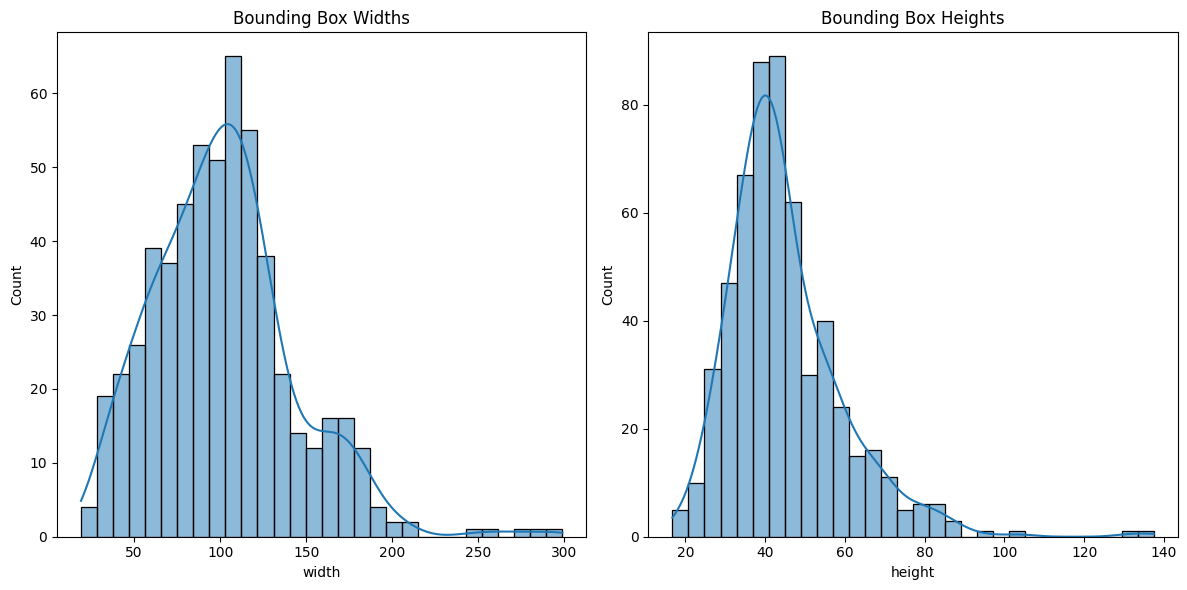

In [8]:
import seaborn as sns
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['width'], bins=30, kde=True)
plt.title('Bounding Box Widths')

plt.subplot(1, 2, 2)
sns.histplot(df['height'], bins=30, kde=True)
plt.title('Bounding Box Heights')

plt.tight_layout()
plt.show()

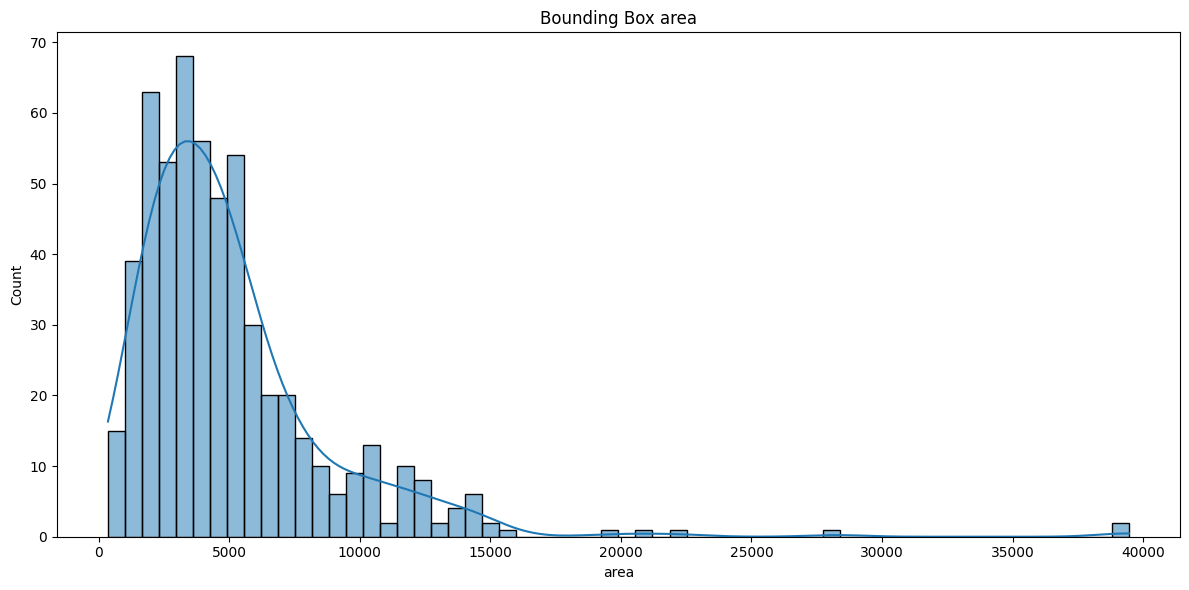

In [9]:
plt.figure(figsize=(12, 6))
sns.histplot(df['area'], bins=60, kde=True)
plt.title('Bounding Box area')

plt.tight_layout()
plt.show()

Podgląd danych

In [10]:
import cv2
import matplotlib.pyplot as plt
def img_box_viewer(img_path, points):
    img = cv2.imread(img_path)
    print(img.shape)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x1, y1, x2, y2 = points
    cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), color=(255, 0, 0), thickness=2)
    plt.imshow(img)
    plt.axis('off')
    plt.show()


(380, 676, 3)


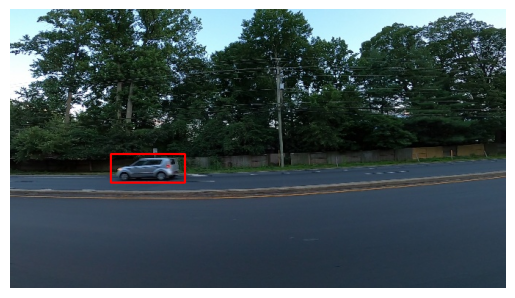

In [11]:
idx = 23
image_path = df['image_path'][idx]
points = df.iloc[idx, 1:5]
img_box_viewer(image_path, points)

Tworzenie yaml dla YOLO

normalizacja danych

In [12]:
from PIL import Image
import pandas as pd

def normalize_coordinates(row):
    try:
        with Image.open(row['image_path']) as img:
            img_w, img_h = img.size
    except:
        return pd.Series([None] * 4)

    x_center = row['x_center'] / img_w
    y_center = row['y_center'] / img_h
    width = row['width'] / img_w
    height = row['height'] / img_h

    return pd.Series([x_center, y_center, width, height])

df[['x_center_norm', 'y_center_norm', 'width_norm', 'height_norm']] = df.apply(normalize_coordinates, axis=1)


podzial

In [13]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

tworzenie struktury dla yolo. foldery

In [14]:
import os

for split in ['train', 'val']:
    os.makedirs(f'data/images/{split}', exist_ok=True)
    os.makedirs(f'data/labels/{split}', exist_ok=True)

dane do folderów

In [15]:
import shutil

def save_yolo_labels(df_split, split):
    for img_name in df_split['image'].unique():
        rows = df_split[df_split['image'] == img_name]

        # Ścieżki
        txt_path = f'data/labels/{split}/{img_name.replace(".jpg", ".txt")}'
        img_src = rows.iloc[0]['image_path']
        img_dst = f'data/images/{split}/{img_name}'

        # Zapis etykiet
        with open(txt_path, 'w') as f:
            for _, row in rows.iterrows():
                if pd.isna(row['x_center_norm']):
                    continue
                f.write(f"{int(row['class_id'])} {row['x_center_norm']:.6f} {row['y_center_norm']:.6f} {row['width_norm']:.6f} {row['height_norm']:.6f}\n")

        # Kopiuj obraz do folderu images/train lub images/val
        shutil.copy(img_src, img_dst)

save_yolo_labels(train_df, 'train')
save_yolo_labels(val_df, 'val')

plik yaml

In [16]:
yaml_content = """
train: /content/data/images/train
val: /content/data/images/val

nc: 1
names: ['car']
"""

with open('data.yaml', 'w') as f:
    f.write(yaml_content.strip())


właczenie YOLO

In [17]:
from ultralytics import YOLO

model = YOLO('yolo11s.pt')
model.train(data='data.yaml', epochs=60, imgsz=640, device='cuda')


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 18.4M/18.4M [00:00<00:00, 89.5MB/s]


Ultralytics 8.3.165 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, 

100%|██████████| 755k/755k [00:00<00:00, 93.6MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytics

 10                  -1  1    990976  ultralytics.nn.modules.block.C2PSA           [512, 512, 1]                 
 11                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 12             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 13                  -1  1    443776  ultralytics.nn.modules.block.C3k2            [768, 256, 1, False]          
 14                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 15             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 16                  -1  1    127680  ultralytics.nn.modules.block.C3k2            [512, 128, 1, False]          
 17                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 18            [-1, 13]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

100%|██████████| 5.35M/5.35M [00:00<00:00, 203MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2625.3±888.0 MB/s, size: 117.8 KB)


train: Scanning /content/data/labels/train... 307 images, 0 backgrounds, 0 corrupt: 100%|██████████| 307/307 [00:00<00:00, 2317.39it/s]

train: New cache created: /content/data/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 626.7±414.8 MB/s, size: 86.1 KB)


val: Scanning /content/data/labels/val... 94 images, 0 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<00:00, 1601.83it/s]

val: New cache created: /content/data/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      3.99G      1.714      4.789      1.278          8        640: 100%|██████████| 20/20 [00:09<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]

                   all         94        112      0.613      0.875      0.727      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      4.04G      1.341      1.427      1.134         16        640: 100%|██████████| 20/20 [00:06<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.63it/s]

                   all         94        112      0.562      0.857      0.571      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      4.09G      1.362      1.071      1.162          9        640: 100%|██████████| 20/20 [00:06<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.21it/s]

                   all         94        112      0.514      0.839      0.637      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      4.13G      1.384      1.087      1.154         15        640: 100%|██████████| 20/20 [00:05<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.70it/s]

                   all         94        112      0.549      0.653      0.533      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      4.18G      1.365     0.9457      1.147         14        640: 100%|██████████| 20/20 [00:06<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.80it/s]

                   all         94        112       0.15     0.0804     0.0582     0.0267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      4.21G      1.348     0.9131      1.132          8        640: 100%|██████████| 20/20 [00:06<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all         94        112      0.364     0.0268     0.0223     0.0177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      4.25G      1.345     0.8425      1.152          9        640: 100%|██████████| 20/20 [00:05<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.06it/s]

                   all         94        112      0.678     0.0625     0.0587     0.0327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      4.29G       1.28     0.7842      1.142          8        640: 100%|██████████| 20/20 [00:06<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.76it/s]

                   all         94        112      0.575       0.42      0.426      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      4.33G       1.27     0.8016      1.119         13        640: 100%|██████████| 20/20 [00:05<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.00it/s]

                   all         94        112      0.567      0.866      0.674      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      4.37G      1.306      0.797      1.151          7        640: 100%|██████████| 20/20 [00:06<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.89it/s]

                   all         94        112      0.593      0.848      0.625      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      4.41G       1.31     0.7853       1.14         11        640: 100%|██████████| 20/20 [00:05<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.72it/s]

                   all         94        112      0.578      0.894      0.664      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      4.48G      1.285     0.7686      1.148          4        640: 100%|██████████| 20/20 [00:06<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.66it/s]

                   all         94        112      0.572      0.946      0.651      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      4.52G      1.236     0.7479      1.126          6        640: 100%|██████████| 20/20 [00:06<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]

                   all         94        112      0.555      0.866      0.665      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60       4.6G      1.256     0.7467      1.111          5        640: 100%|██████████| 20/20 [00:05<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.25it/s]

                   all         94        112      0.592       0.83      0.691      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      4.63G      1.245     0.7232      1.107          3        640: 100%|██████████| 20/20 [00:06<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.88it/s]

                   all         94        112      0.574      0.866      0.707      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      4.68G      1.196     0.7368      1.096          7        640: 100%|██████████| 20/20 [00:05<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.70it/s]

                   all         94        112      0.574      0.927        0.7       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      4.75G      1.233     0.7777      1.126          9        640: 100%|██████████| 20/20 [00:06<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.15it/s]

                   all         94        112      0.541      0.927      0.603      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      4.79G      1.185     0.7182      1.082         11        640: 100%|██████████| 20/20 [00:05<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]

                   all         94        112       0.56       0.92      0.683      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      4.86G      1.192     0.7254      1.067         14        640: 100%|██████████| 20/20 [00:05<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.30it/s]

                   all         94        112      0.575      0.964      0.654      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60       4.9G      1.179     0.7189      1.098          7        640: 100%|██████████| 20/20 [00:06<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.41it/s]

                   all         94        112      0.557      0.956      0.687      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      4.94G      1.194     0.6995      1.093          5        640: 100%|██████████| 20/20 [00:05<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.08it/s]

                   all         94        112      0.571      0.964      0.628      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      5.02G      1.147     0.6862      1.054          7        640: 100%|██████████| 20/20 [00:06<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.05it/s]

                   all         94        112      0.582      0.959      0.665      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      5.05G      1.086      0.642      1.059          7        640: 100%|██████████| 20/20 [00:05<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.58it/s]

                   all         94        112      0.572      0.982      0.623      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      5.13G      1.142     0.6855      1.057          9        640: 100%|██████████| 20/20 [00:06<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.80it/s]

                   all         94        112      0.558      0.866      0.642      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      5.17G      1.125     0.6615      1.087          9        640: 100%|██████████| 20/20 [00:06<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]

                   all         94        112      0.517      0.509      0.464       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      5.24G      1.094     0.6585       1.06         14        640: 100%|██████████| 20/20 [00:05<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.82it/s]

                   all         94        112      0.564      0.902      0.657      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      5.28G      1.154     0.6612      1.093          5        640: 100%|██████████| 20/20 [00:06<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.84it/s]

                   all         94        112       0.56      0.982      0.603      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      5.35G      1.125     0.6486      1.064         12        640: 100%|██████████| 20/20 [00:05<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.91it/s]

                   all         94        112      0.553      0.964      0.607      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      5.39G      1.097     0.6521      1.044          5        640: 100%|██████████| 20/20 [00:06<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.15it/s]

                   all         94        112      0.567      0.899      0.629      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      5.43G      1.118     0.6322      1.064          7        640: 100%|██████████| 20/20 [00:06<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]

                   all         94        112      0.553      0.938      0.599      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      5.51G      1.139     0.6504      1.079          8        640: 100%|██████████| 20/20 [00:06<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.78it/s]

                   all         94        112      0.557      0.964      0.637      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      5.54G      1.074     0.6116      1.066          7        640: 100%|██████████| 20/20 [00:06<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.24it/s]

                   all         94        112      0.564      0.982      0.591      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      5.62G      1.095     0.6517      1.056          8        640: 100%|██████████| 20/20 [00:05<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.94it/s]

                   all         94        112      0.561      0.973       0.61      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      5.66G      1.082     0.6251      1.045          8        640: 100%|██████████| 20/20 [00:06<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.88it/s]

                   all         94        112       0.57      0.982      0.608        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60       5.7G      1.131     0.6415      1.074         13        640: 100%|██████████| 20/20 [00:05<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.68it/s]

                   all         94        112      0.561       0.98      0.614      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      5.77G      1.087     0.5944      1.067          4        640: 100%|██████████| 20/20 [00:06<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.74it/s]

                   all         94        112      0.561      0.955      0.679      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      5.81G      1.059     0.6257      1.034         11        640: 100%|██████████| 20/20 [00:06<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.14it/s]

                   all         94        112      0.562      0.973        0.6      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      5.88G       1.01     0.5715     0.9997          9        640: 100%|██████████| 20/20 [00:05<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.81it/s]

                   all         94        112      0.555      0.964      0.646       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      5.92G      1.055     0.5864      1.034          4        640: 100%|██████████| 20/20 [00:06<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.06it/s]

                   all         94        112      0.575      0.931      0.607      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60         6G      1.028     0.5827       1.03         11        640: 100%|██████████| 20/20 [00:06<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.81it/s]

                   all         94        112      0.554      0.982      0.609      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      6.04G      1.006     0.5813      1.013         10        640: 100%|██████████| 20/20 [00:06<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.14it/s]

                   all         94        112      0.561      0.973      0.618      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      6.11G      1.039     0.5858      1.017         10        640: 100%|██████████| 20/20 [00:06<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.68it/s]

                   all         94        112      0.561      0.957        0.6      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      6.15G      1.009      0.573      1.013          7        640: 100%|██████████| 20/20 [00:05<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.03it/s]

                   all         94        112      0.557      0.982       0.61      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      6.19G      1.063     0.5842      1.028         10        640: 100%|██████████| 20/20 [00:06<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.78it/s]

                   all         94        112      0.554      0.964      0.615       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      6.26G      1.005     0.5912      1.026          3        640: 100%|██████████| 20/20 [00:06<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.98it/s]

                   all         94        112      0.574      0.929      0.624      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60       6.3G     0.9566     0.5635     0.9948          5        640: 100%|██████████| 20/20 [00:06<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.11it/s]

                   all         94        112      0.563      0.964      0.613      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      6.37G      1.001      0.557      1.013          7        640: 100%|██████████| 20/20 [00:06<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]

                   all         94        112      0.566      0.964      0.629      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      6.41G     0.9755     0.5346      1.013          4        640: 100%|██████████| 20/20 [00:05<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.89it/s]

                   all         94        112      0.555      0.981      0.669      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      6.45G       0.95     0.5443      1.003          9        640: 100%|██████████| 20/20 [00:06<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.81it/s]

                   all         94        112      0.553      0.964      0.607      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      6.53G     0.9844      0.565      1.006         10        640: 100%|██████████| 20/20 [00:05<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.04it/s]

                   all         94        112      0.568      0.929      0.639      0.413


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      6.66G     0.9643     0.5439      1.027          4        640: 100%|██████████| 20/20 [00:08<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.20it/s]

                   all         94        112      0.552      0.982      0.644      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60       6.7G     0.9807     0.5424      1.016          5        640: 100%|██████████| 20/20 [00:06<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]

                   all         94        112      0.564      0.911      0.615       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      6.74G     0.9541     0.5381      1.023          3        640: 100%|██████████| 20/20 [00:05<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.09it/s]

                   all         94        112      0.551      0.955      0.609      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      6.78G     0.9437     0.5378      1.006          5        640: 100%|██████████| 20/20 [00:06<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.14it/s]

                   all         94        112      0.554      0.963      0.603      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      6.82G     0.9054     0.5217     0.9804          4        640: 100%|██████████| 20/20 [00:05<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.08it/s]

                   all         94        112      0.555      0.946      0.615      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      6.86G     0.9222     0.5114     0.9857          3        640: 100%|██████████| 20/20 [00:06<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.78it/s]

                   all         94        112      0.546      0.964      0.622       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60       6.9G     0.8952     0.5182     0.9684          9        640: 100%|██████████| 20/20 [00:06<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all         94        112      0.543      0.964      0.606      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      6.94G     0.8971     0.5086     0.9824          8        640: 100%|██████████| 20/20 [00:05<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.92it/s]

                   all         94        112      0.547      0.964      0.601      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      7.02G     0.8781     0.5028     0.9789          3        640: 100%|██████████| 20/20 [00:06<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.33it/s]

                   all         94        112      0.554      0.954       0.61      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      7.06G     0.8857     0.5047     0.9753          5        640: 100%|██████████| 20/20 [00:05<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.36it/s]

                   all         94        112      0.556      0.952      0.602      0.395



60 epochs completed in 0.129 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 19.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 19.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.165 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]


                   all         94        112      0.561      0.955      0.679      0.458
Speed: 0.1ms preprocess, 3.2ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ceabad4ef90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

TEST MODELU

In [20]:
model = YOLO('runs/detect/train/weights/best.pt')


image 1/1 /content/car-object-detection/data/testing_images/vid_5_400.jpg: 384x640 1 car, 18.2ms
Speed: 3.2ms preprocess, 18.2ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


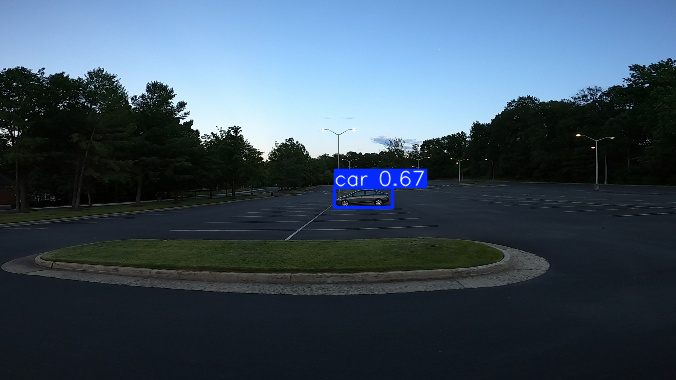

In [26]:
results = model('/content/car-object-detection/data/testing_images/vid_5_400.jpg')
results[0].show()


image 1/1 /content/car-object-detection/data/testing_images/vid_5_31160.jpg: 384x640 1 car, 68.0ms
Speed: 3.0ms preprocess, 68.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


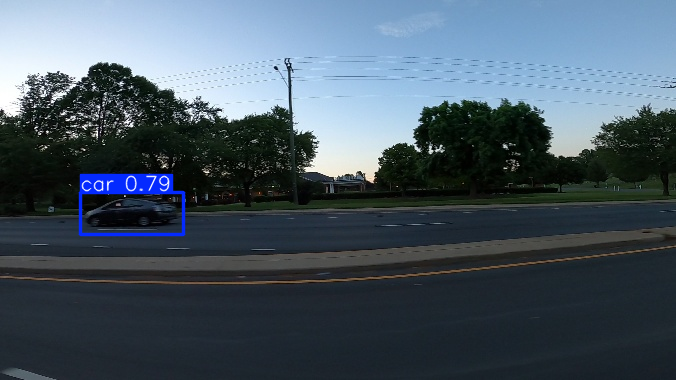

In [29]:
results = model('/content/car-object-detection/data/testing_images/vid_5_31160.jpg')
results[0].show()


image 1/1 /content/car-object-detection/data/testing_images/vid_5_26720.jpg: 384x640 3 cars, 52.1ms
Speed: 11.0ms preprocess, 52.1ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


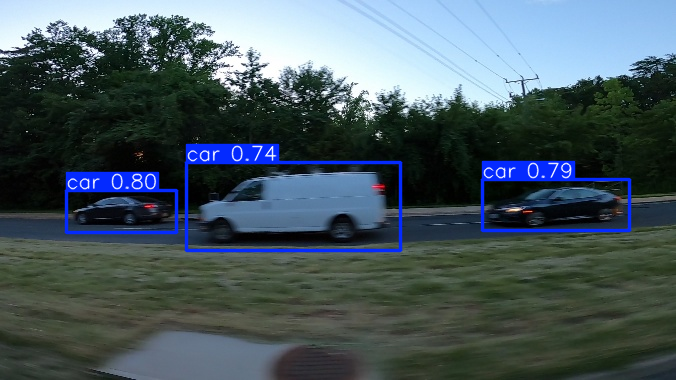

In [30]:
results = model('/content/car-object-detection/data/testing_images/vid_5_26720.jpg')
results[0].show()